In [1]:
%matplotlib inline
import cv2
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
import numpy as np 
import tensorflow as tf
print(tf.__version__)
from matplotlib import pyplot

2.3.0


In [2]:
import sys
sys.path.append('ULTDocBin/')
import pandas as pd
pd.set_option('display.float_format','{:.4f}'.format)
from dataUtils import collect_binarization_by_dataset, DataGenerator
from testUtils import prepare_inference, find_best_model
from layerUtils import *
from modelUtils import *
from metrics import *

In [3]:
dataset_lut = collect_binarization_by_dataset('Dataset')
#Create Model
model = create_multiscale_ULT(
                                window_size_list=[7,15,23,31,39,47,55,63],
                                train_k=1,
                                train_R=1,
                                base_filters=8,
                                norm_type="bnorm"
                                )
model.summary()

Model: "ULT_v3_att_w7.15.23.31.39.47.55.63_k1_R1_a0_bnorm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img01_inp (InputLayer)          [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 8 80          img01_inp[0][0]                  
__________________________________________________________________________________________________
bnorm0 (BatchNormalization)     (None, None, None, 8 32          conv0[0][0]                      
__________________________________________________________________________________________________
relu0 (Activation)              (None, None, None, 8 0           bnorm0[0][0]                     
__________________________________________________

INFO: seek best models in pretrained_models/
INFO: found best weight pretrained_models/ULT_v3_att_w7.15.23.31.39.47.55.63_k1_R1_a0_bnorm_S256_R0.00_B8_lr0.001_E07-Acc0.9951-Tacc0.9755-F0.9730-PSNR23.54.h5


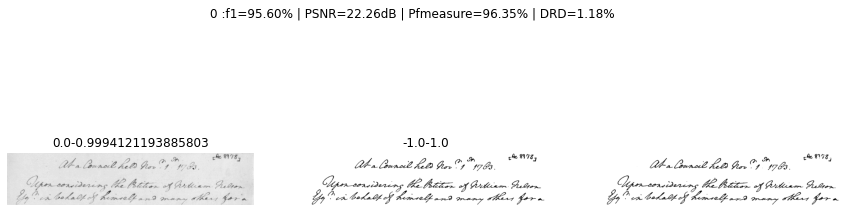

Total average : [95.6  96.4  22.3   1.18]
INFO: seek best models in pretrained_models/
INFO: found best weight pretrained_models/ULT_v3_att_w7.15.23.31.39.47.55.63_k1_R1_a0_bnorm_S256_R0.00_B8_lr0.001_E07-Acc0.9951-Tacc0.9755-F0.9730-PSNR23.54.h5


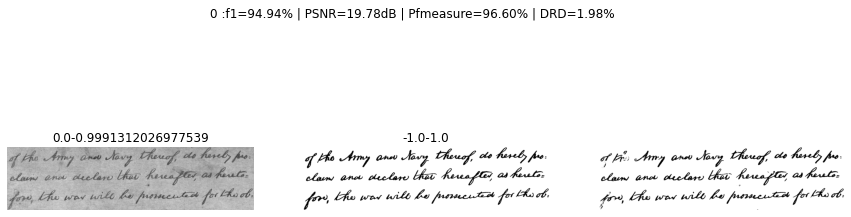

Total average : [94.9  96.6  19.8   1.98]
INFO: seek best models in pretrained_models/
INFO: found best weight pretrained_models/ULT_v3_att_w7.15.23.31.39.47.55.63_k1_R1_a0_bnorm_S256_R0.00_B8_lr0.001_E07-Acc0.9951-Tacc0.9755-F0.9730-PSNR23.54.h5


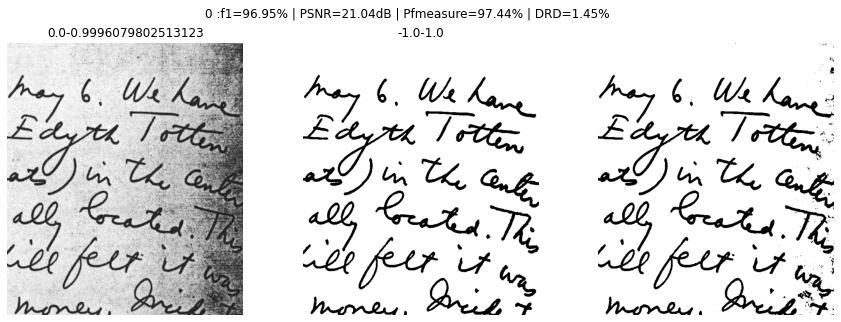

Total average : [97.   97.4  21.    1.45]
INFO: seek best models in pretrained_models/
INFO: found best weight pretrained_models/ULT_v3_att_w7.15.23.31.39.47.55.63_k1_R1_a0_bnorm_S256_R0.00_B8_lr0.001_E07-Acc0.9951-Tacc0.9755-F0.9730-PSNR23.54.h5


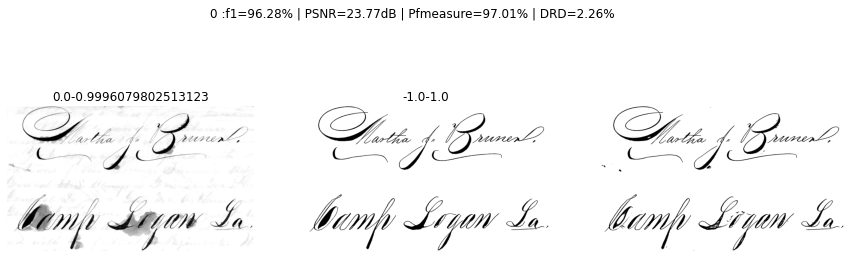

Total average : [96.3  97.   23.8   2.26]
INFO: seek best models in pretrained_models/
INFO: found best weight pretrained_models/ULT_v3_att_w7.15.23.31.39.47.55.63_k1_R1_a0_bnorm_S256_R0.00_B8_lr0.001_E07-Acc0.9951-Tacc0.9755-F0.9730-PSNR23.54.h5


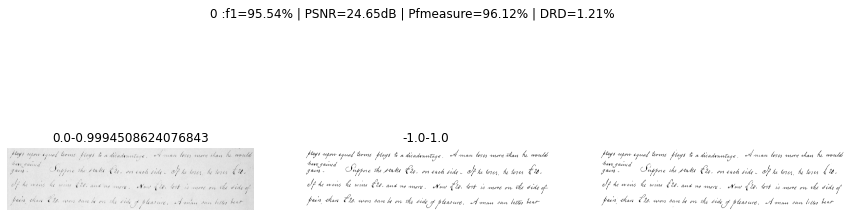

Total average : [95.5  96.1  24.7   1.21]
INFO: seek best models in pretrained_models/
INFO: found best weight pretrained_models/ULT_v3_att_w7.15.23.31.39.47.55.63_k1_R1_a0_bnorm_S256_R0.00_B8_lr0.001_E07-Acc0.9951-Tacc0.9755-F0.9730-PSNR23.54.h5


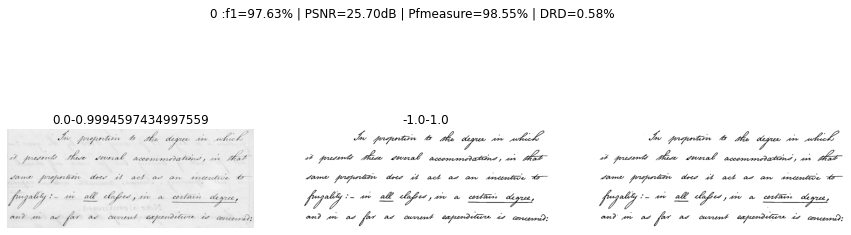

Total average : [97.6  98.6  25.7   0.58]
INFO: seek best models in pretrained_models/
INFO: found best weight pretrained_models/ULT_v3_att_w7.15.23.31.39.47.55.63_k1_R1_a0_bnorm_S256_R0.00_B8_lr0.001_E07-Acc0.9951-Tacc0.9755-F0.9730-PSNR23.54.h5


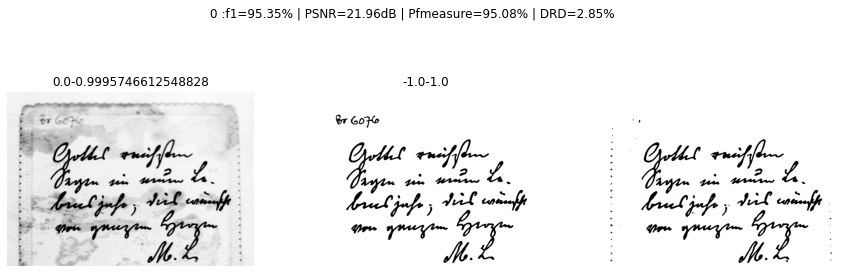

Total average : [95.4  95.1  22.    2.85]


In [4]:
Testing_dataset = ['DIBCO2009','DIBCO2010', 'DIBCO2011', 'DIBCO2012','DIBCO2013', 'DIBCO2014', 'DIBCO2016']
metrics = []
for dataset in Testing_dataset:
    all_metrics = []
    model_dir = 'pretrained_models/'
    model_dir = find_best_model(model_dir, criterion='F1', lower_is_better=False)
    #Load Pretrained Weights
    model.load_weights(model_dir)
    test_datagen = DataGenerator(dataset_lut[dataset], output_shape=None, mode='testing')
    L = len(test_datagen)
    for i in range(L) :
        x, y = test_datagen[i]
        z = model.predict(x)
        
        pyplot.figure(figsize=(15,5))
        pyplot.subplot(131)
        pyplot.axis("off")
        pyplot.imshow(x[0,...,0], cmap='gray')
        pyplot.title('{}-{}'.format(x.min(), x.max()))
        pyplot.subplot(132)
        pyplot.axis("off")
        pyplot.imshow(y[0,...,0], cmap='gray', vmin=-1, vmax=1)
        pyplot.title('{}-{}'.format(y.min(), y.max()))
        pyplot.subplot(133)
        pyplot.axis("off")
        pyplot.imshow(z[0,...,0]>0, cmap='gray', vmin=0, vmax=1)
        
        f1 = Fmeasure(z[0,...,0]>0,y[0,...,0]>0)
        psnr = Psnr(z[0,...,0]>0,y[0,...,0]>0)
        Pf = Pfmeasure(z[0,...,0]>0,y[0,...,0]>0)
        drd = DRD(z[0,...,0]>0,y[0,...,0]>0)
        all_metrics.append([round(f1*100,1), round(Pf*100,1),round(psnr,1), round(drd,2)])
        pyplot.suptitle(f'{i} :f1={f1*100:.2f}% | PSNR={psnr:.2f}dB | Pfmeasure={Pf*100:.2f}% | DRD={drd:.2f}%')
        pyplot.show()
    print("Total average : " + str(np.mean(all_metrics,axis=0)))

